CLINICAL TRIAL STROKE RISK PREDICTION - VERSION 3


PART 1: DATA GENERATION

✓ Generated demographics data for 1000 subjects
✓ Generated 20000 vital signs records
✓ Generated 24000 laboratory records
✓ Generated stroke outcomes, stroke rate: 5.9%
✓ Generated 2009 adverse event records
✓ Generated 1000 exposure records

✓ All data saved to CSV files

DATA QUALITY VALIDATION
Demographics   :   1000 records,   0 missing values
Vital Signs    :  20000 records,   0 missing values
Laboratory     :  24000 records,   0 missing values
Outcomes       :   1000 records,   0 missing values

Stroke Distribution:
  Total subjects: 1000
  Stroke events: 59 (5.9%)
  No stroke: 941 (94.1%)
  Imbalance ratio: 15.9:1

Stroke Rate by Treatment Group:
           count  sum      mean
ARM                            
CONTROL      490   35  0.071429
TREATMENT    510   24  0.047059


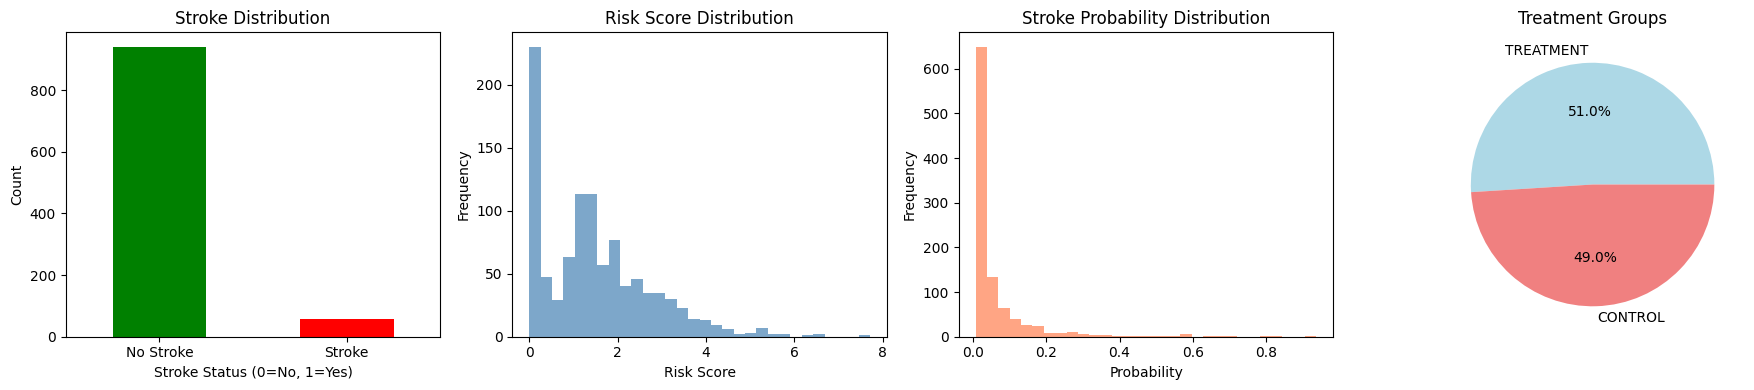


DATA PREPARATION FOR MODELING
✓ Dataset prepared: 1000 subjects, 20 features

Creating clinical data visualizations...


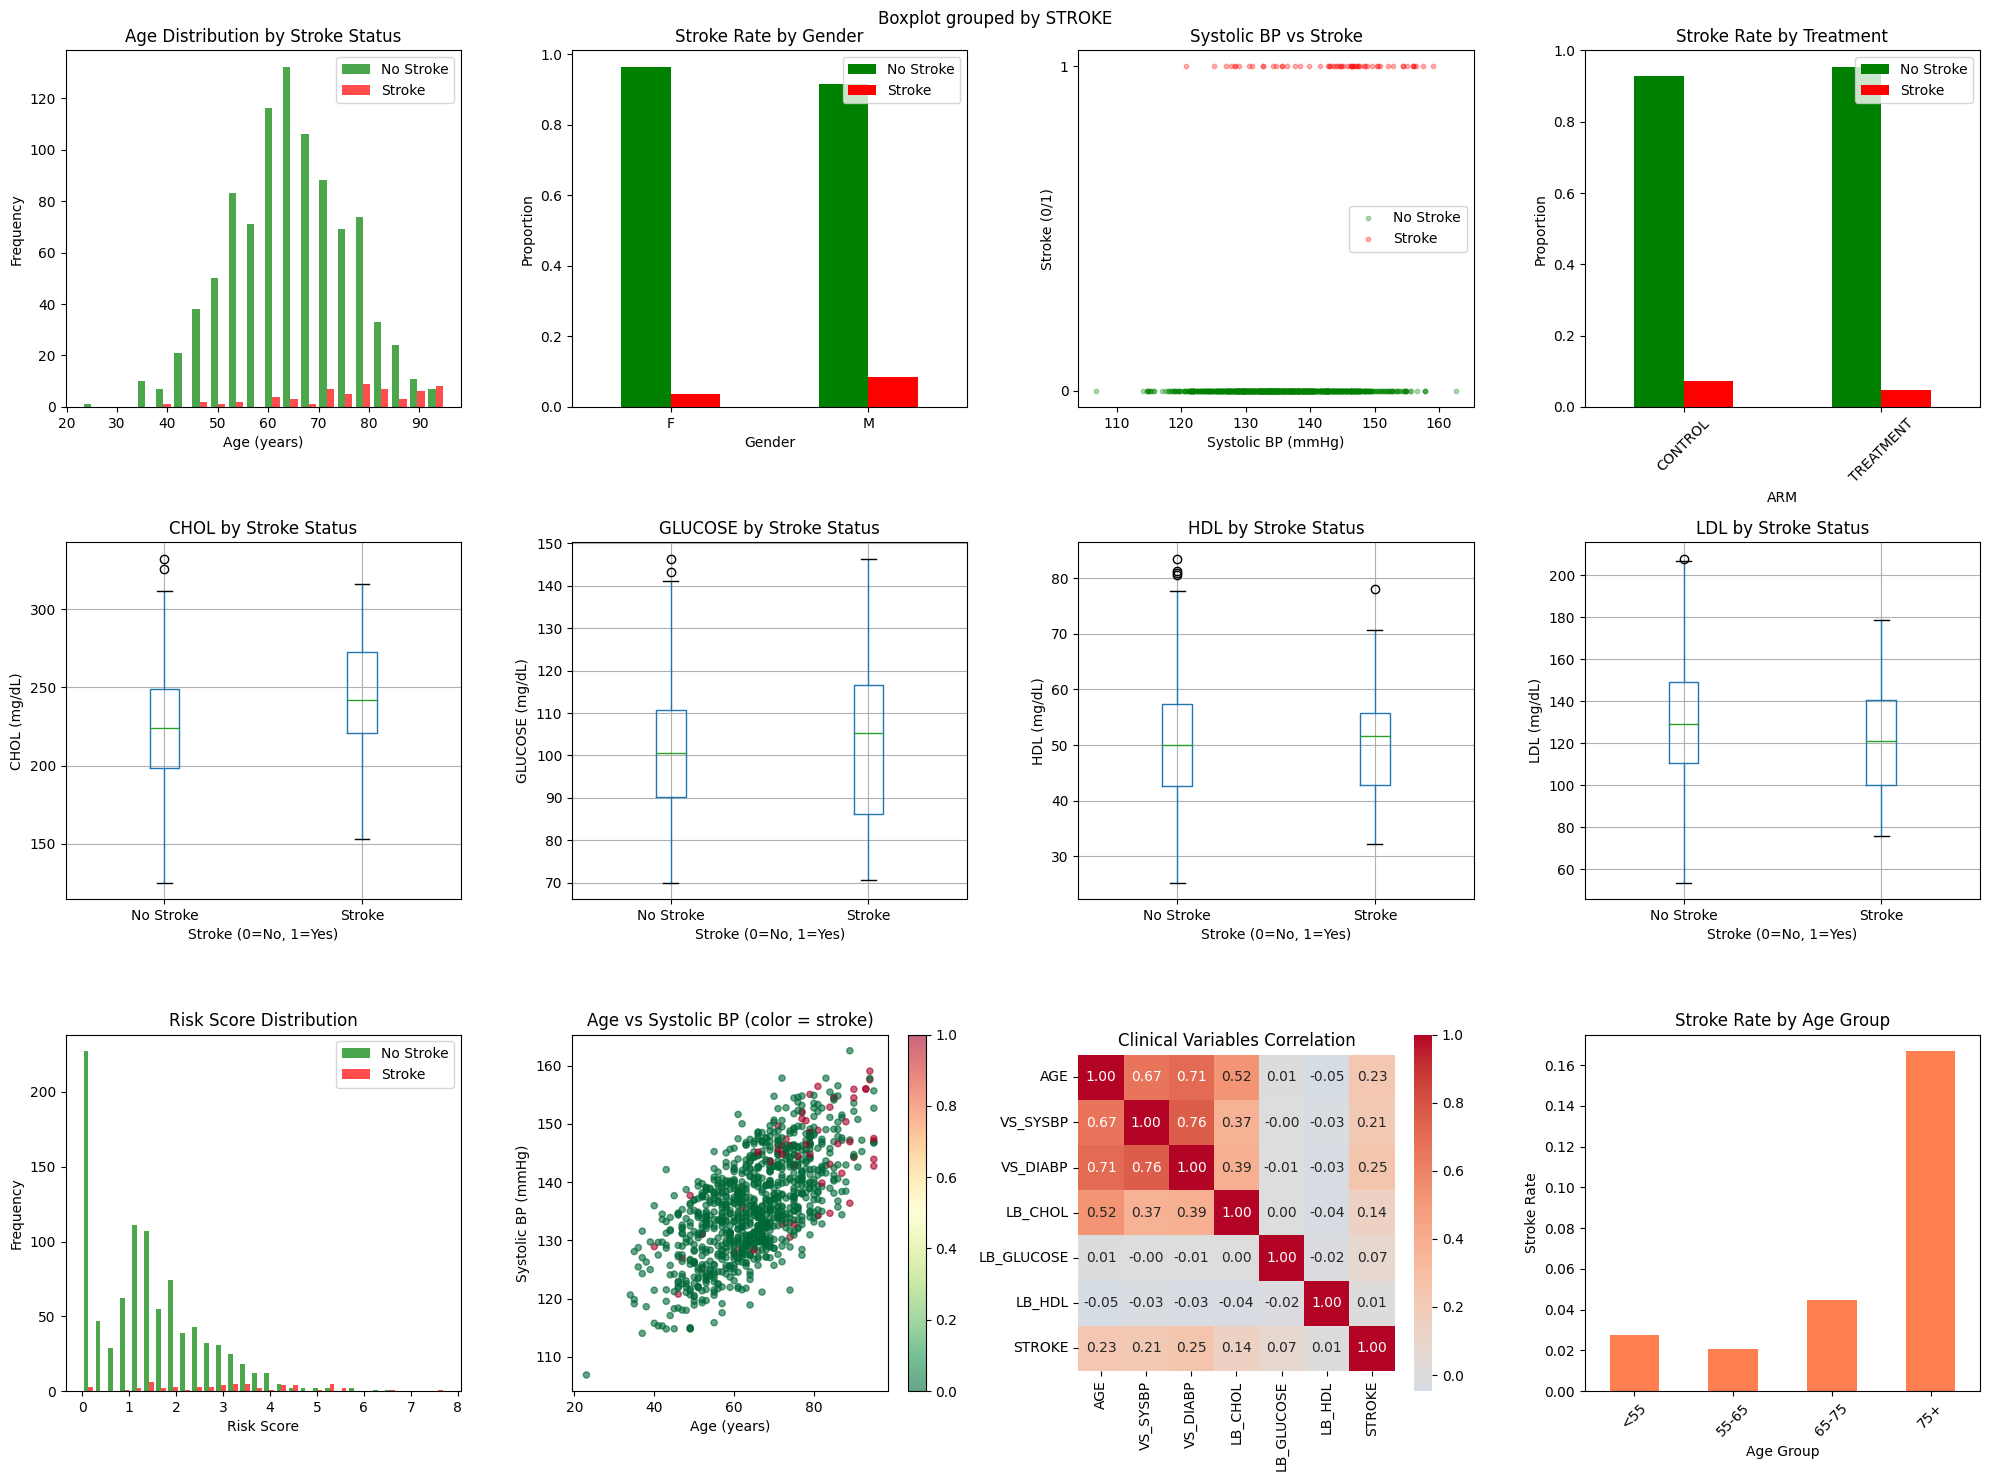


CLINICAL SUMMARY STATISTICS
Overall stroke rate: 5.9%
Mean age: 65.3 ± 12.0 years
Mean systolic BP: 136.0 ± 8.7 mmHg

Stroke rates by demographic groups:

By Gender:
     count  sum   mean
SEX                   
F      543   20  0.037
M      457   39  0.085

By Treatment:
           count  sum   mean
ARM                         
CONTROL      490   35  0.071
TREATMENT    510   24  0.047

MODEL BUILDING & TRAINING

Feature Engineering:
  Total features: 21
  Total samples: 1000
  Stroke rate: 5.9%
  Imbalance ratio: 15.9:1

Data Split:
  Training: 800 samples (5.9% stroke)
  Testing: 200 samples (6.0% stroke)

--------------------------------------------------------------------------------
TRAINING MODELS
--------------------------------------------------------------------------------

>>> Logistic Regression
----------------------------------------
  Training model...

  Test Set Performance:
    AUC:       0.750
    Recall:    0.583 ⭐ (stroke detection rate)
    Precision: 0.123
    F

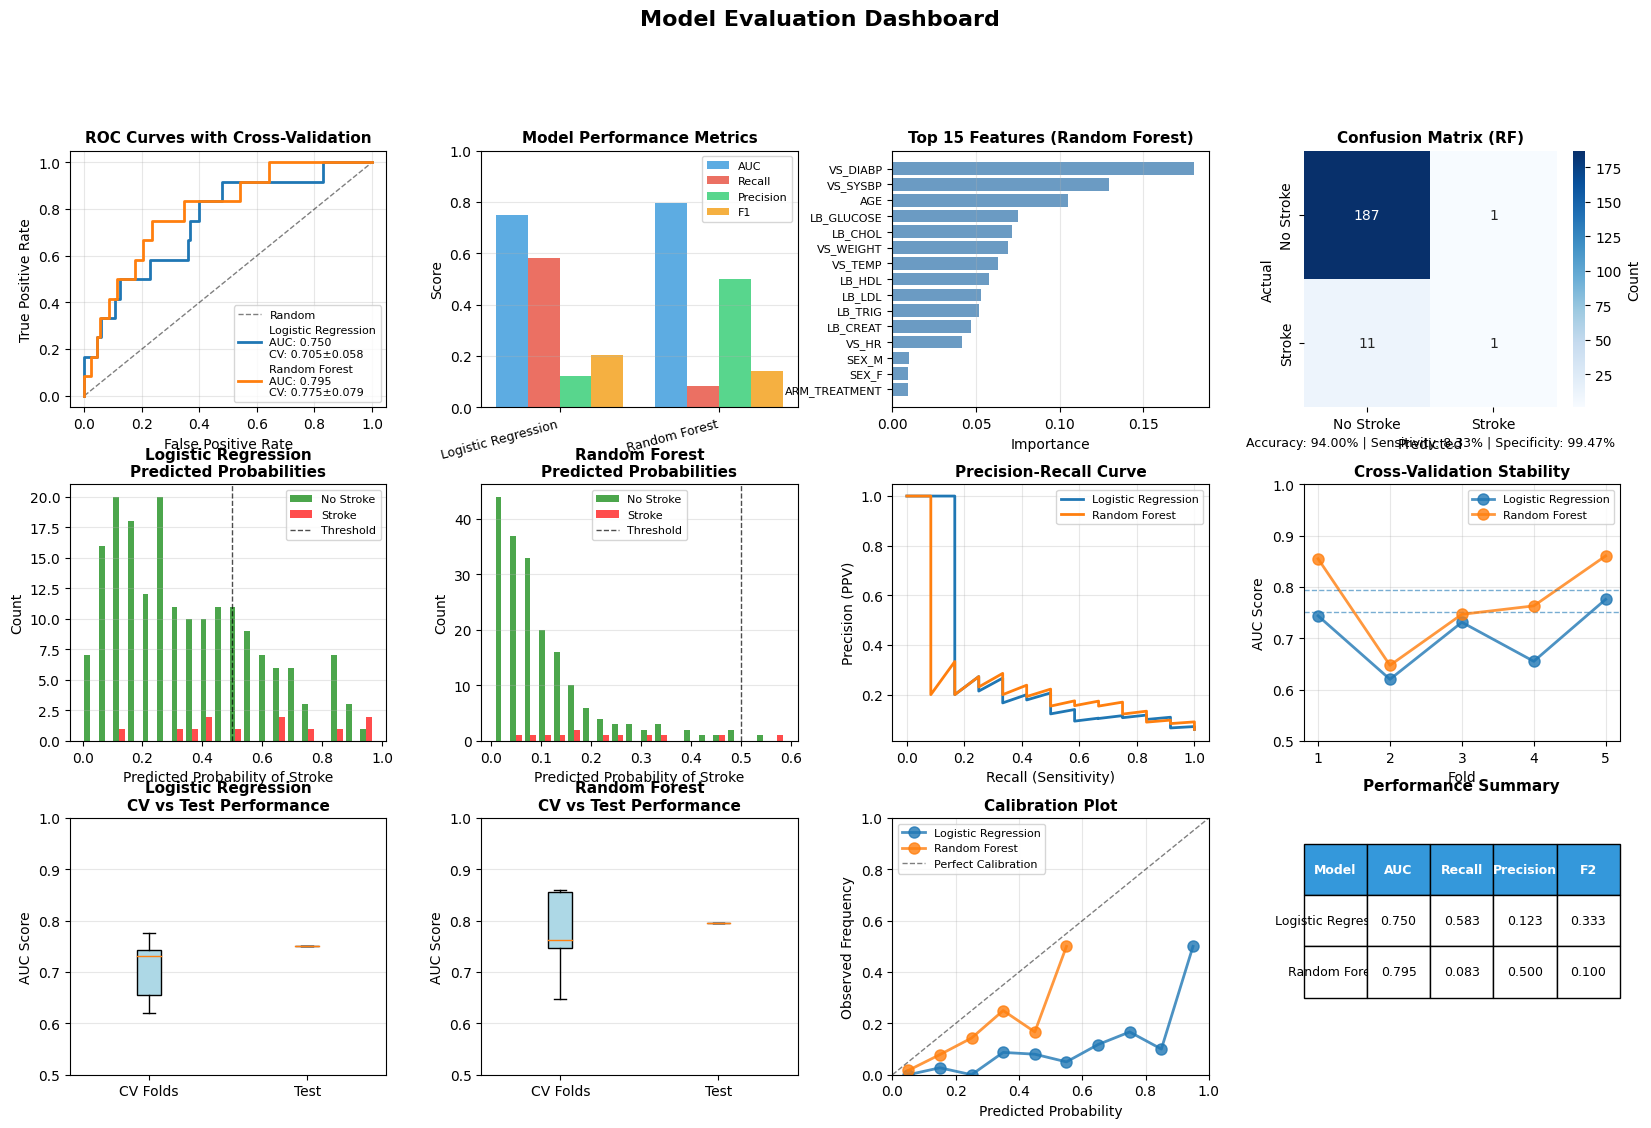


DETAILED MODEL PERFORMANCE METRICS

Logistic Regression:
  Cross-Validation (5-fold):
    Mean AUC:  0.705 ± 0.058
    CV Scores: ['0.744', '0.620', '0.731', '0.655', '0.776']
  Test Set:
    AUC:       0.750
    Recall:    0.583 ⭐ (stroke detection)
    Precision: 0.123
    F1-Score:  0.203
    F2-Score:  0.333 (emphasizes recall)

Random Forest:
  Cross-Validation (5-fold):
    Mean AUC:  0.775 ± 0.079
    CV Scores: ['0.855', '0.648', '0.747', '0.763', '0.861']
  Test Set:
    AUC:       0.795
    Recall:    0.083 ⭐ (stroke detection)
    Precision: 0.500
    F1-Score:  0.143
    F2-Score:  0.100 (emphasizes recall)

STROKE RISK CALCULATOR: Random Forest
Test AUC:      0.795
CV AUC:        0.775 ± 0.079
Recall:        0.083 ⭐ (catches 8% of strokes)
Precision:     0.500
Configuration: 500 trees, balanced classes, optimized hyperparameters

EXAMPLE PREDICTIONS

Example 1: High-risk patient

PATIENT PROFILE
Demographics: 72yo M, WHITE, CONTROL
Vital Signs:  SBP=150 mmHg, DBP=80 mmHg,

In [1]:
# ============================================================================
# Clinical Trial Stroke Risk Prediction - Enhanced Version 3
# 
# Combines:
#   - Beautiful visualizations from Version 1
#   - Model improvements from Version 2 (500 trees, class_weight, CV)
# 
# Features:
#   - CDISC-compliant synthetic clinical trial data
#   - Optimized Random Forest (500 trees with class balancing)
#   - 5-fold cross-validation with confidence intervals
#   - Comprehensive visualization dashboard
#   - Production-ready stroke risk calculator
# ============================================================================

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve,
                            confusion_matrix, recall_score, precision_score,
                            f1_score, fbeta_score, precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

print("=" * 80)
print("CLINICAL TRIAL STROKE RISK PREDICTION - VERSION 3")
print("=" * 80 + "\n")


# ============================================================================
# PART 1: DATA GENERATION
# Generate synthetic clinical trial data following CDISC standards
# ============================================================================

def generate_demographics(n_subjects=1000):
    """Generate demographic data following CDISC DM domain"""
    subjects = []
    for i in range(1, n_subjects + 1):
        subject = {
            'SUBJID': f'SUBJ{i:04d}',
            'AGE': np.random.normal(65, 12),
            'SEX': np.random.choice(['M', 'F'], p=[0.48, 0.52]),
            'RACE': np.random.choice(['WHITE', 'BLACK', 'ASIAN', 'HISPANIC', 'OTHER'],
                                    p=[0.6, 0.15, 0.15, 0.08, 0.02]),
            'ARM': np.random.choice(['TREATMENT', 'CONTROL'], p=[0.5, 0.5]),
            'RFSTDTC': datetime(2023, 1, 1) + timedelta(days=np.random.randint(0, 365))
        }
        subject['AGE'] = max(18, min(95, subject['AGE']))
        subjects.append(subject)
    
    df_dm = pd.DataFrame(subjects)
    df_dm['AGE'] = df_dm['AGE'].round(0).astype(int)
    print(f"✓ Generated demographics data for {len(df_dm)} subjects")
    return df_dm


def generate_vital_signs(df_dm, visits_per_subject=4):
    """Generate vital signs data following CDISC VS domain"""
    vs_records = []
    for _, subject in df_dm.iterrows():
        subjid = subject['SUBJID']
        age = subject['AGE']
        sex = subject['SEX']
        
        base_sbp = 120 + (age - 50) * 0.5 + (10 if sex == 'M' else 0)
        base_dbp = 80 + (age - 50) * 0.3 + (5 if sex == 'M' else 0)
        base_hr = 70 + np.random.normal(0, 5)
        base_temp = 36.5 + np.random.normal(0, 0.3)
        base_weight = 70 + (10 if sex == 'M' else -5) + np.random.normal(0, 8)
        
        for visit in range(1, visits_per_subject + 1):
            visit_date = subject['RFSTDTC'] + timedelta(days=visit * 30)
            trend_factor = 1 + (visit - 1) * 0.02
            
            vs_records.extend([
                {'SUBJID': subjid, 'VSTESTCD': 'SYSBP', 'VSTEST': 'Systolic Blood Pressure',
                 'VSORRES': max(90, base_sbp * trend_factor + np.random.normal(0, 8)),
                 'VSORRESU': 'mmHg', 'VSDTC': visit_date, 'VISIT': f'VISIT_{visit}'},
                {'SUBJID': subjid, 'VSTESTCD': 'DIABP', 'VSTEST': 'Diastolic Blood Pressure',
                 'VSORRES': max(60, base_dbp * trend_factor + np.random.normal(0, 5)),
                 'VSORRESU': 'mmHg', 'VSDTC': visit_date, 'VISIT': f'VISIT_{visit}'},
                {'SUBJID': subjid, 'VSTESTCD': 'HR', 'VSTEST': 'Heart Rate',
                 'VSORRES': max(50, base_hr + np.random.normal(0, 8)),
                 'VSORRESU': 'beats/min', 'VSDTC': visit_date, 'VISIT': f'VISIT_{visit}'},
                {'SUBJID': subjid, 'VSTESTCD': 'TEMP', 'VSTEST': 'Temperature',
                 'VSORRES': base_temp + np.random.normal(0, 0.2),
                 'VSORRESU': 'C', 'VSDTC': visit_date, 'VISIT': f'VISIT_{visit}'},
                {'SUBJID': subjid, 'VSTESTCD': 'WEIGHT', 'VSTEST': 'Weight',
                 'VSORRES': max(40, base_weight + np.random.normal(0, 2)),
                 'VSORRESU': 'kg', 'VSDTC': visit_date, 'VISIT': f'VISIT_{visit}'}
            ])
    
    df_vs = pd.DataFrame(vs_records)
    df_vs['VSORRES'] = df_vs['VSORRES'].round(1)
    print(f"✓ Generated {len(df_vs)} vital signs records")
    return df_vs


def generate_lab_data(df_dm, visits_per_subject=4):
    """Generate laboratory data following CDISC LB domain"""
    lb_records = []
    for _, subject in df_dm.iterrows():
        subjid = subject['SUBJID']
        age = subject['AGE']
        
        base_glucose = 100 + np.random.normal(0, 15)
        base_cholesterol = 200 + (age - 50) * 1.5 + np.random.normal(0, 30)
        base_hdl = 50 + np.random.normal(0, 10)
        base_ldl = 130 + np.random.normal(0, 25)
        base_triglycerides = 150 + np.random.normal(0, 40)
        base_creatinine = 1.0 + np.random.normal(0, 0.2)
        
        for visit in range(1, visits_per_subject + 1):
            visit_date = subject['RFSTDTC'] + timedelta(days=visit * 30)
            
            lb_records.extend([
                {'SUBJID': subjid, 'LBTESTCD': 'GLUCOSE', 'LBTEST': 'Glucose',
                 'LBORRES': max(70, base_glucose + np.random.normal(0, 10)),
                 'LBORRESU': 'mg/dL', 'LBDTC': visit_date, 'VISIT': f'VISIT_{visit}'},
                {'SUBJID': subjid, 'LBTESTCD': 'CHOL', 'LBTEST': 'Total Cholesterol',
                 'LBORRES': max(120, base_cholesterol + np.random.normal(0, 15)),
                 'LBORRESU': 'mg/dL', 'LBDTC': visit_date, 'VISIT': f'VISIT_{visit}'},
                {'SUBJID': subjid, 'LBTESTCD': 'HDL', 'LBTEST': 'HDL Cholesterol',
                 'LBORRES': max(25, base_hdl + np.random.normal(0, 8)),
                 'LBORRESU': 'mg/dL', 'LBDTC': visit_date, 'VISIT': f'VISIT_{visit}'},
                {'SUBJID': subjid, 'LBTESTCD': 'LDL', 'LBTEST': 'LDL Cholesterol',
                 'LBORRES': max(50, base_ldl + np.random.normal(0, 20)),
                 'LBORRESU': 'mg/dL', 'LBDTC': visit_date, 'VISIT': f'VISIT_{visit}'},
                {'SUBJID': subjid, 'LBTESTCD': 'TRIG', 'LBTEST': 'Triglycerides',
                 'LBORRES': max(50, base_triglycerides + np.random.normal(0, 30)),
                 'LBORRESU': 'mg/dL', 'LBDTC': visit_date, 'VISIT': f'VISIT_{visit}'},
                {'SUBJID': subjid, 'LBTESTCD': 'CREAT', 'LBTEST': 'Creatinine',
                 'LBORRES': max(0.5, base_creatinine + np.random.normal(0, 0.1)),
                 'LBORRESU': 'mg/dL', 'LBDTC': visit_date, 'VISIT': f'VISIT_{visit}'}
            ])
    
    df_lb = pd.DataFrame(lb_records)
    df_lb['LBORRES'] = df_lb['LBORRES'].round(2)
    print(f"✓ Generated {len(df_lb)} laboratory records")
    return df_lb


def generate_stroke_outcomes(df_dm, df_vs, df_lb):
    """Generate stroke outcomes based on clinical risk factors"""
    outcomes = []
    
    vs_pivot = df_vs.pivot_table(index='SUBJID', columns='VSTESTCD',
                                 values='VSORRES', aggfunc='mean').reset_index()
    lb_pivot = df_lb.pivot_table(index='SUBJID', columns='LBTESTCD',
                                 values='LBORRES', aggfunc='mean').reset_index()
    
    merged_data = df_dm.merge(vs_pivot, on='SUBJID', how='left')
    merged_data = merged_data.merge(lb_pivot, on='SUBJID', how='left')
    
    for _, row in merged_data.iterrows():
        risk_score = 0
        
        if row['AGE'] > 65:
            risk_score += (row['AGE'] - 65) * 0.1
        if 'SYSBP' in row and pd.notna(row['SYSBP']) and row['SYSBP'] > 140:
            risk_score += (row['SYSBP'] - 140) * 0.05
        if 'CHOL' in row and pd.notna(row['CHOL']) and row['CHOL'] > 240:
            risk_score += (row['CHOL'] - 240) * 0.02
        if row['SEX'] == 'M':
            risk_score += 1.5
        if row['RACE'] == 'BLACK':
            risk_score += 1.0
        if 'GLUCOSE' in row and pd.notna(row['GLUCOSE']) and row['GLUCOSE'] > 126:
            risk_score += 2.0
        if row['ARM'] == 'TREATMENT':
            risk_score *= 0.8
        
        probability = 1 / (1 + np.exp(-(risk_score - 5)))
        stroke = np.random.random() < probability
        
        outcomes.append({
            'SUBJID': row['SUBJID'],
            'STROKE': int(stroke),
            'RISK_SCORE': round(risk_score, 2),
            'STROKE_PROBABILITY': round(probability, 3)
        })
    
    df_outcomes = pd.DataFrame(outcomes)
    print(f"✓ Generated stroke outcomes, stroke rate: {df_outcomes['STROKE'].mean():.1%}")
    return df_outcomes


def generate_adverse_events(df_dm, df_outcomes):
    """Generate adverse events data following CDISC AE domain"""
    ae_records = []
    ae_terms = ['HYPERTENSION', 'DIZZINESS', 'HEADACHE', 'FATIGUE', 'NAUSEA',
                'CHEST PAIN', 'PALPITATIONS', 'EDEMA', 'SHORTNESS OF BREATH', 'MUSCLE CRAMPS']
    
    for _, subject in df_dm.iterrows():
        n_aes = np.random.poisson(2)
        for ae_num in range(n_aes):
            ae_start = subject['RFSTDTC'] + timedelta(days=np.random.randint(1, 365))
            ae_records.append({
                'SUBJID': subject['SUBJID'],
                'AESEQ': ae_num + 1,
                'AETERM': np.random.choice(ae_terms),
                'AESTDTC': ae_start,
                'AESEV': np.random.choice(['MILD', 'MODERATE', 'SEVERE'], p=[0.6, 0.3, 0.1])
            })
    
    df_ae = pd.DataFrame(ae_records)
    print(f"✓ Generated {len(df_ae)} adverse event records")
    return df_ae


def generate_exposure_data(df_dm):
    """Generate exposure data following CDISC EX domain"""
    ex_records = []
    for _, subject in df_dm.iterrows():
        treatment = subject['ARM']
        drug_name = 'STUDY DRUG' if treatment == 'TREATMENT' else 'PLACEBO'
        dose = '10 mg' if treatment == 'TREATMENT' else 'N/A'
        actual_duration = min(365, np.random.exponential(300))
        
        ex_records.append({
            'SUBJID': subject['SUBJID'],
            'EXTRT': drug_name,
            'EXDOSE': dose,
            'EXSTDTC': subject['RFSTDTC'],
            'EXENDTC': subject['RFSTDTC'] + timedelta(days=int(actual_duration)),
            'EXDUR': int(actual_duration)
        })
    
    df_ex = pd.DataFrame(ex_records)
    print(f"✓ Generated {len(df_ex)} exposure records")
    return df_ex


# ============================================================================
# PART 2: DATA QUALITY VALIDATION
# Display data overview and quality metrics
# ============================================================================

def validate_data_quality(df_dm, df_vs, df_lb, df_outcomes):
    """Validate data quality and display overview"""
    print("\n" + "=" * 80)
    print("DATA QUALITY VALIDATION")
    print("=" * 80)
    
    # Check for missing values
    datasets = [('Demographics', df_dm), ('Vital Signs', df_vs), 
                ('Laboratory', df_lb), ('Outcomes', df_outcomes)]
    
    for name, df in datasets:
        missing = df.isnull().sum().sum()
        print(f"{name:15s}: {len(df):6d} records, {missing:3d} missing values")
    
    # Stroke distribution
    print(f"\nStroke Distribution:")
    print(f"  Total subjects: {len(df_outcomes)}")
    print(f"  Stroke events: {df_outcomes['STROKE'].sum()} ({df_outcomes['STROKE'].mean():.1%})")
    print(f"  No stroke: {(df_outcomes['STROKE']==0).sum()} ({(df_outcomes['STROKE']==0).mean():.1%})")
    print(f"  Imbalance ratio: {(df_outcomes['STROKE']==0).sum()/(df_outcomes['STROKE']==1).sum():.1f}:1")
    
    # Treatment groups
    stroke_by_arm = df_dm.merge(df_outcomes, on='SUBJID')[['ARM', 'STROKE']].groupby('ARM')['STROKE'].agg(['count', 'sum', 'mean'])
    print(f"\nStroke Rate by Treatment Group:")
    print(stroke_by_arm)
    
    # Create visualization
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    
    # Stroke distribution
    df_outcomes['STROKE'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
    axes[0].set_title('Stroke Distribution')
    axes[0].set_xlabel('Stroke Status (0=No, 1=Yes)')
    axes[0].set_ylabel('Count')
    axes[0].set_xticklabels(['No Stroke', 'Stroke'], rotation=0)
    
    # Risk score distribution
    axes[1].hist(df_outcomes['RISK_SCORE'], bins=30, alpha=0.7, color='steelblue')
    axes[1].set_title('Risk Score Distribution')
    axes[1].set_xlabel('Risk Score')
    axes[1].set_ylabel('Frequency')
    
    # Stroke probability
    axes[2].hist(df_outcomes['STROKE_PROBABILITY'], bins=30, alpha=0.7, color='coral')
    axes[2].set_title('Stroke Probability Distribution')
    axes[2].set_xlabel('Probability')
    axes[2].set_ylabel('Frequency')
    
    # Treatment groups
    df_dm['ARM'].value_counts().plot(kind='pie', ax=axes[3], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
    axes[3].set_title('Treatment Groups')
    axes[3].set_ylabel('')
    
    plt.tight_layout()
    plt.show()


# ============================================================================
# PART 3: DATA PREPARATION
# Merge and aggregate data for modeling
# ============================================================================

def prepare_modeling_dataset(df_dm, df_vs, df_lb, df_outcomes):
    """Prepare dataset for modeling"""
    print("\n" + "=" * 80)
    print("DATA PREPARATION FOR MODELING")
    print("=" * 80)
    
    # Aggregate vital signs
    vs_pivot = df_vs.pivot_table(index='SUBJID', columns='VSTESTCD',
                                 values='VSORRES', aggfunc='mean')
    vs_pivot.columns = [f'VS_{col}' for col in vs_pivot.columns]
    vs_pivot = vs_pivot.reset_index()
    
    # Aggregate laboratory values
    lb_pivot = df_lb.pivot_table(index='SUBJID', columns='LBTESTCD',
                                 values='LBORRES', aggfunc='mean')
    lb_pivot.columns = [f'LB_{col}' for col in lb_pivot.columns]
    lb_pivot = lb_pivot.reset_index()
    
    # Merge all datasets
    modeling_data = df_dm.copy()
    modeling_data = modeling_data.merge(vs_pivot, on='SUBJID', how='left')
    modeling_data = modeling_data.merge(lb_pivot, on='SUBJID', how='left')
    modeling_data = modeling_data.merge(df_outcomes, on='SUBJID', how='left')
    
    print(f"✓ Dataset prepared: {len(modeling_data)} subjects, {len(modeling_data.columns)} features")
    return modeling_data


# ============================================================================
# PART 4: CLINICAL DATA VISUALIZATION
# Comprehensive exploratory data analysis
# ============================================================================

def plot_clinical_distributions(df_modeling):
    """Create comprehensive clinical data visualizations"""
    print("\nCreating clinical data visualizations...")
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle('Clinical Data Distribution & Risk Factor Analysis', fontsize=16, y=0.995)
    
    # 1. Age distribution by stroke
    axes[0,0].hist([df_modeling[df_modeling['STROKE']==0]['AGE'],
                    df_modeling[df_modeling['STROKE']==1]['AGE']],
                   bins=20, alpha=0.7, label=['No Stroke', 'Stroke'], color=['green', 'red'])
    axes[0,0].set_title('Age Distribution by Stroke Status')
    axes[0,0].set_xlabel('Age (years)')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].legend()
    
    # 2. Gender and stroke
    stroke_by_gender = pd.crosstab(df_modeling['SEX'], df_modeling['STROKE'], normalize='index')
    stroke_by_gender.plot(kind='bar', ax=axes[0,1], rot=0, color=['green', 'red'])
    axes[0,1].set_title('Stroke Rate by Gender')
    axes[0,1].set_ylabel('Proportion')
    axes[0,1].set_xlabel('Gender')
    axes[0,1].legend(['No Stroke', 'Stroke'])
    
    # 3. Blood pressure vs stroke
    if 'VS_SYSBP' in df_modeling.columns:
        for stroke_val, color, label in [(0, 'green', 'No Stroke'), (1, 'red', 'Stroke')]:
            data = df_modeling[df_modeling['STROKE']==stroke_val]['VS_SYSBP']
            axes[0,2].scatter(data, [stroke_val]*len(data), alpha=0.3, s=10, color=color, label=label)
        axes[0,2].set_title('Systolic BP vs Stroke')
        axes[0,2].set_xlabel('Systolic BP (mmHg)')
        axes[0,2].set_ylabel('Stroke (0/1)')
        axes[0,2].set_yticks([0, 1])
        axes[0,2].legend()
    
    # 4. Treatment effect
    stroke_by_arm = pd.crosstab(df_modeling['ARM'], df_modeling['STROKE'], normalize='index')
    stroke_by_arm.plot(kind='bar', ax=axes[0,3], rot=45, color=['green', 'red'])
    axes[0,3].set_title('Stroke Rate by Treatment')
    axes[0,3].set_ylabel('Proportion')
    axes[0,3].legend(['No Stroke', 'Stroke'])
    
    # 5-8. Laboratory values by stroke
    lab_features = ['LB_CHOL', 'LB_GLUCOSE', 'LB_HDL', 'LB_LDL']
    for i, feature in enumerate(lab_features):
        if feature in df_modeling.columns:
            row, col = (i+4)//4, (i+4)%4
            df_modeling.boxplot(column=feature, by='STROKE', ax=axes[row,col])
            axes[row,col].set_title(f'{feature.replace("LB_", "")} by Stroke Status')
            axes[row,col].set_xlabel('Stroke (0=No, 1=Yes)')
            axes[row,col].set_ylabel(f'{feature.replace("LB_", "")} (mg/dL)')
            plt.sca(axes[row,col])
            plt.xticks([1, 2], ['No Stroke', 'Stroke'])
    
    # 9. Risk score distribution
    if 'RISK_SCORE' in df_modeling.columns:
        axes[2,0].hist([df_modeling[df_modeling['STROKE']==0]['RISK_SCORE'],
                        df_modeling[df_modeling['STROKE']==1]['RISK_SCORE']],
                       bins=30, alpha=0.7, label=['No Stroke', 'Stroke'], color=['green', 'red'])
        axes[2,0].set_title('Risk Score Distribution')
        axes[2,0].set_xlabel('Risk Score')
        axes[2,0].set_ylabel('Frequency')
        axes[2,0].legend()
    
    # 10. Age vs Blood Pressure
    if 'VS_SYSBP' in df_modeling.columns:
        scatter = axes[2,1].scatter(df_modeling['AGE'], df_modeling['VS_SYSBP'],
                                   c=df_modeling['STROKE'], cmap='RdYlGn_r', alpha=0.6, s=20)
        axes[2,1].set_title('Age vs Systolic BP (color = stroke)')
        axes[2,1].set_xlabel('Age (years)')
        axes[2,1].set_ylabel('Systolic BP (mmHg)')
        plt.colorbar(scatter, ax=axes[2,1])
    
    # 11. Correlation heatmap
    clinical_vars = ['AGE', 'VS_SYSBP', 'VS_DIABP', 'LB_CHOL', 'LB_GLUCOSE', 'LB_HDL', 'STROKE']
    clinical_vars = [var for var in clinical_vars if var in df_modeling.columns]
    if len(clinical_vars) > 2:
        corr_matrix = df_modeling[clinical_vars].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                   ax=axes[2,2], fmt='.2f', square=True)
        axes[2,2].set_title('Clinical Variables Correlation')
    
    # 12. Stroke rate by age group
    df_modeling['AGE_GROUP'] = pd.cut(df_modeling['AGE'],
                                      bins=[0, 55, 65, 75, 100],
                                      labels=['<55', '55-65', '65-75', '75+'])
    age_stroke = df_modeling.groupby('AGE_GROUP')['STROKE'].mean()
    age_stroke.plot(kind='bar', ax=axes[2,3], rot=45, color='coral')
    axes[2,3].set_title('Stroke Rate by Age Group')
    axes[2,3].set_ylabel('Stroke Rate')
    axes[2,3].set_xlabel('Age Group')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "=" * 80)
    print("CLINICAL SUMMARY STATISTICS")
    print("=" * 80)
    print(f"Overall stroke rate: {df_modeling['STROKE'].mean():.1%}")
    print(f"Mean age: {df_modeling['AGE'].mean():.1f} ± {df_modeling['AGE'].std():.1f} years")
    if 'VS_SYSBP' in df_modeling.columns:
        print(f"Mean systolic BP: {df_modeling['VS_SYSBP'].mean():.1f} ± {df_modeling['VS_SYSBP'].std():.1f} mmHg")
    
    print("\nStroke rates by demographic groups:")
    print("\nBy Gender:")
    print(df_modeling.groupby('SEX')['STROKE'].agg(['count', 'sum', 'mean']).round(3))
    print("\nBy Treatment:")
    print(df_modeling.groupby('ARM')['STROKE'].agg(['count', 'sum', 'mean']).round(3))
    print("=" * 80)


# ============================================================================
# PART 5: MODEL BUILDING WITH ENHANCEMENTS
# Train optimized models with cross-validation
# ============================================================================

def build_stroke_prediction_models(df_modeling, n_folds=5):
    """Build enhanced prediction models with optimizations"""
    print("\n" + "=" * 80)
    print("MODEL BUILDING & TRAINING")
    print("=" * 80)
    
    # Prepare features
    feature_columns = ['AGE']
    vs_features = [col for col in df_modeling.columns if col.startswith('VS_')]
    lab_features = [col for col in df_modeling.columns if col.startswith('LB_')]
    feature_columns.extend(vs_features + lab_features)
    feature_columns = [col for col in feature_columns if col in df_modeling.columns]
    
    X = df_modeling[feature_columns].copy()
    y = df_modeling['STROKE'].copy()
    
    # Add categorical features
    for cat_feature in ['SEX', 'RACE', 'ARM']:
        if cat_feature in df_modeling.columns:
            dummies = pd.get_dummies(df_modeling[cat_feature], prefix=cat_feature)
            X = pd.concat([X, dummies], axis=1)
    
    X = X.fillna(X.mean())
    
    print(f"\nFeature Engineering:")
    print(f"  Total features: {X.shape[1]}")
    print(f"  Total samples: {X.shape[0]}")
    print(f"  Stroke rate: {y.mean():.1%}")
    print(f"  Imbalance ratio: {(1-y.mean())/y.mean():.1f}:1")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\nData Split:")
    print(f"  Training: {len(X_train)} samples ({y_train.mean():.1%} stroke)")
    print(f"  Testing: {len(X_test)} samples ({y_test.mean():.1%} stroke)")
    
    # Scale features for Logistic Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models with optimizations
    models = {
        'Logistic Regression': LogisticRegression(
            random_state=42,
            max_iter=1000,
            class_weight='balanced'  # Handle imbalance
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=500,           # Optimized: 500 instead of 10,000
            random_state=42,
            max_depth=15,               # Prevent overfitting
            min_samples_split=10,       # More robust splits
            min_samples_leaf=4,         # Smoother predictions
            class_weight='balanced',    # Handle imbalance
            n_jobs=-1                   # Use all CPU cores
        )
    }
    
    results = {}
    
    print("\n" + "-" * 80)
    print("TRAINING MODELS")
    print("-" * 80)
    
    for name, model in models.items():
        print(f"\n>>> {name}")
        print("-" * 40)
        
        # Select appropriate data
        if name == 'Logistic Regression':
            X_train_use = X_train_scaled
            X_test_use = X_test_scaled
        else:
            X_train_use = X_train
            X_test_use = X_test
        
        # Train model
        print("  Training model...")
        model.fit(X_train_use, y_train)
        
        # Predictions
        y_pred_proba = model.predict_proba(X_test_use)[:, 1]
        y_pred = model.predict(X_test_use)
        
        # Calculate metrics
        auc_score = roc_auc_score(y_test, y_pred_proba)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred)
        f2 = fbeta_score(y_test, y_pred, beta=2)  # Emphasizes recall
        
        print(f"\n  Test Set Performance:")
        print(f"    AUC:       {auc_score:.3f}")
        print(f"    Recall:    {recall:.3f} ⭐ (stroke detection rate)")
        print(f"    Precision: {precision:.3f}")
        print(f"    F1-Score:  {f1:.3f}")
        print(f"    F2-Score:  {f2:.3f}")
        
        # Cross-validation
        print(f"\n  Running {n_folds}-Fold Cross-Validation...")
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train_use, y_train,
                                    cv=skf, scoring='roc_auc', n_jobs=-1)
        
        mean_cv = np.mean(cv_scores)
        std_cv = np.std(cv_scores)
        ci_lower = mean_cv - 1.96 * std_cv
        ci_upper = mean_cv + 1.96 * std_cv
        
        print(f"    CV AUC:    {mean_cv:.3f} ± {std_cv:.3f}")
        print(f"    95% CI:    ({ci_lower:.3f}, {ci_upper:.3f})")
        print(f"    CV Folds:  {[f'{score:.3f}' for score in cv_scores]}")
        
        # Confusion matrix analysis
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        print(f"\n  Confusion Matrix:")
        print(f"    True Negatives:  {tn}")
        print(f"    False Positives: {fp}")
        print(f"    False Negatives: {fn} ⚠️  (missed strokes)")
        print(f"    True Positives:  {tp}")
        print(f"    Stroke Detection: {tp}/{tp+fn} ({tp/(tp+fn) if (tp+fn)>0 else 0:.1%})")
        
        # Store results
        results[name] = {
            'model': model,
            'scaler': scaler if name == 'Logistic Regression' else None,
            'auc': auc_score,
            'recall': recall,
            'precision': precision,
            'f1': f1,
            'f2': f2,
            'y_pred_proba': y_pred_proba,
            'y_pred': y_pred,
            'cv_mean': mean_cv,
            'cv_std': std_cv,
            'cv_scores': cv_scores,
            'confusion_matrix': cm,
            'features': X.columns.tolist()
        }
    
    print("\n" + "=" * 80)
    print("MODEL TRAINING COMPLETE")
    print("=" * 80)
    
    return results, X_test, y_test


# ============================================================================
# PART 6: MODEL EVALUATION VISUALIZATIONS
# Comprehensive model performance dashboard
# ============================================================================

def plot_model_evaluation(results, X_test, y_test):
    """Create comprehensive model evaluation visualizations"""
    print("\nCreating model evaluation dashboard...")
    
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # 1. ROC Curves
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1, label='Random')
    
    for name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        label = f"{name}\nAUC: {result['auc']:.3f}\nCV: {result['cv_mean']:.3f}±{result['cv_std']:.3f}"
        ax1.plot(fpr, tpr, linewidth=2, label=label)
    
    ax1.set_xlabel('False Positive Rate', fontsize=10)
    ax1.set_ylabel('True Positive Rate', fontsize=10)
    ax1.set_title('ROC Curves with Cross-Validation', fontweight='bold', fontsize=11)
    ax1.legend(loc='lower right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # 2. Model Comparison
    ax2 = fig.add_subplot(gs[0, 1])
    model_names = list(results.keys())
    metrics_data = {
        'AUC': [results[name]['auc'] for name in model_names],
        'Recall': [results[name]['recall'] for name in model_names],
        'Precision': [results[name]['precision'] for name in model_names],
        'F1': [results[name]['f1'] for name in model_names]
    }
    
    x = np.arange(len(model_names))
    width = 0.2
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    
    for i, (metric, values) in enumerate(metrics_data.items()):
        ax2.bar(x + i*width, values, width, label=metric, color=colors[i], alpha=0.8)
    
    ax2.set_ylabel('Score', fontsize=10)
    ax2.set_title('Model Performance Metrics', fontweight='bold', fontsize=11)
    ax2.set_xticks(x + width * 1.5)
    ax2.set_xticklabels(model_names, rotation=15, ha='right', fontsize=9)
    ax2.legend(fontsize=8)
    ax2.set_ylim(0, 1.0)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Feature Importance (Random Forest)
    if 'Random Forest' in results:
        ax3 = fig.add_subplot(gs[0, 2])
        rf_result = results['Random Forest']
        importance_df = pd.DataFrame({
            'feature': rf_result['features'],
            'importance': rf_result['model'].feature_importances_
        }).sort_values('importance', ascending=False).head(15)
        
        ax3.barh(range(len(importance_df)), importance_df['importance'], color='steelblue', alpha=0.8)
        ax3.set_yticks(range(len(importance_df)))
        ax3.set_yticklabels(importance_df['feature'], fontsize=8)
        ax3.set_xlabel('Importance', fontsize=10)
        ax3.set_title('Top 15 Features (Random Forest)', fontweight='bold', fontsize=11)
        ax3.invert_yaxis()
        ax3.grid(True, alpha=0.3, axis='x')
    
    # 4. Confusion Matrix Heatmap
    ax4 = fig.add_subplot(gs[0, 3])
    cm = results['Random Forest']['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
               xticklabels=['No Stroke', 'Stroke'],
               yticklabels=['No Stroke', 'Stroke'],
               cbar_kws={'label': 'Count'})
    ax4.set_title('Confusion Matrix (RF)', fontweight='bold', fontsize=11)
    ax4.set_ylabel('Actual', fontsize=10)
    ax4.set_xlabel('Predicted', fontsize=10)
    
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ax4.text(1, 2.3, f'Accuracy: {accuracy:.2%} | Sensitivity: {sensitivity:.2%} | Specificity: {specificity:.2%}',
            ha='center', fontsize=9, transform=ax4.transData)
    
    # 5-6. Prediction Probability Distributions
    for i, (name, result) in enumerate(results.items()):
        ax = fig.add_subplot(gs[1, i])
        prob_no_stroke = result['y_pred_proba'][y_test == 0]
        prob_stroke = result['y_pred_proba'][y_test == 1]
        
        ax.hist([prob_no_stroke, prob_stroke], bins=20, alpha=0.7,
               label=['No Stroke', 'Stroke'], color=['green', 'red'])
        ax.axvline(x=0.5, color='k', linestyle='--', linewidth=1, alpha=0.7, label='Threshold')
        ax.set_title(f'{name}\nPredicted Probabilities', fontweight='bold', fontsize=11)
        ax.set_xlabel('Predicted Probability of Stroke', fontsize=10)
        ax.set_ylabel('Count', fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3, axis='y')
    
    # 7. Precision-Recall Curve
    ax7 = fig.add_subplot(gs[1, 2])
    for name, result in results.items():
        precision, recall, _ = precision_recall_curve(y_test, result['y_pred_proba'])
        ax7.plot(recall, precision, linewidth=2, label=f"{name}")
    
    ax7.set_xlabel('Recall (Sensitivity)', fontsize=10)
    ax7.set_ylabel('Precision (PPV)', fontsize=10)
    ax7.set_title('Precision-Recall Curve', fontweight='bold', fontsize=11)
    ax7.legend(fontsize=8)
    ax7.grid(True, alpha=0.3)
    
    # 8. Cross-Validation Stability
    ax8 = fig.add_subplot(gs[1, 3])
    for name, result in results.items():
        cv_scores = result['cv_scores']
        ax8.plot(range(1, len(cv_scores)+1), cv_scores, marker='o', linewidth=2, 
                markersize=8, label=name, alpha=0.8)
        ax8.axhline(y=result['auc'], linestyle='--', linewidth=1, alpha=0.6)
    
    ax8.set_xlabel('Fold', fontsize=10)
    ax8.set_ylabel('AUC Score', fontsize=10)
    ax8.set_title('Cross-Validation Stability', fontweight='bold', fontsize=11)
    ax8.legend(fontsize=8)
    ax8.grid(True, alpha=0.3)
    ax8.set_ylim(0.5, 1.0)
    
    # 9-10. CV Box Plots
    for i, (name, result) in enumerate(results.items()):
        ax = fig.add_subplot(gs[2, i])
        cv_data = [result['cv_scores'], [result['auc']]]
        bp = ax.boxplot(cv_data, labels=['CV Folds', 'Test'], patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        bp['boxes'][1].set_facecolor('lightcoral')
        ax.set_ylabel('AUC Score', fontsize=10)
        ax.set_title(f'{name}\nCV vs Test Performance', fontweight='bold', fontsize=11)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(0.5, 1.0)
    
    # 11. Calibration Plot
    ax11 = fig.add_subplot(gs[2, 2])
    for name, result in results.items():
        # Bin predictions
        prob_pred = result['y_pred_proba']
        bins = np.linspace(0, 1, 11)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        bin_indices = np.digitize(prob_pred, bins) - 1
        
        bin_sums = np.bincount(bin_indices, weights=y_test, minlength=len(bins)-1)
        bin_counts = np.bincount(bin_indices, minlength=len(bins)-1)
        
        with np.errstate(divide='ignore', invalid='ignore'):
            bin_true = np.where(bin_counts > 0, bin_sums / bin_counts, np.nan)
        
        mask = ~np.isnan(bin_true)
        ax11.plot(bin_centers[mask], bin_true[mask], marker='o', linewidth=2, 
                 markersize=8, label=name, alpha=0.8)
    
    ax11.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Perfect Calibration')
    ax11.set_xlabel('Predicted Probability', fontsize=10)
    ax11.set_ylabel('Observed Frequency', fontsize=10)
    ax11.set_title('Calibration Plot', fontweight='bold', fontsize=11)
    ax11.legend(fontsize=8)
    ax11.grid(True, alpha=0.3)
    ax11.set_xlim(0, 1)
    ax11.set_ylim(0, 1)
    
    # 12. Summary Metrics Table
    ax12 = fig.add_subplot(gs[2, 3])
    ax12.axis('off')
    
    table_data = []
    for name, result in results.items():
        table_data.append([
            name,
            f"{result['auc']:.3f}",
            f"{result['recall']:.3f}",
            f"{result['precision']:.3f}",
            f"{result['f2']:.3f}"
        ])
    
    table = ax12.table(cellText=table_data,
                      colLabels=['Model', 'AUC', 'Recall', 'Precision', 'F2'],
                      cellLoc='center',
                      loc='center',
                      bbox=[0, 0.3, 1, 0.6])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # Style header
    for i in range(5):
        table[(0, i)].set_facecolor('#3498db')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax12.set_title('Performance Summary', fontweight='bold', fontsize=11, pad=20)
    
    plt.suptitle('Model Evaluation Dashboard', fontsize=16, fontweight='bold', y=0.998)
    plt.show()
    
    # Print detailed metrics
    print("\n" + "=" * 80)
    print("DETAILED MODEL PERFORMANCE METRICS")
    print("=" * 80)
    
    for name, result in results.items():
        print(f"\n{name}:")
        print(f"  Cross-Validation (5-fold):")
        print(f"    Mean AUC:  {result['cv_mean']:.3f} ± {result['cv_std']:.3f}")
        print(f"    CV Scores: {[f'{s:.3f}' for s in result['cv_scores']]}")
        print(f"  Test Set:")
        print(f"    AUC:       {result['auc']:.3f}")
        print(f"    Recall:    {result['recall']:.3f} ⭐ (stroke detection)")
        print(f"    Precision: {result['precision']:.3f}")
        print(f"    F1-Score:  {result['f1']:.3f}")
        print(f"    F2-Score:  {result['f2']:.3f} (emphasizes recall)")
    
    print("=" * 80)


# ============================================================================
# PART 7: RISK CALCULATOR
# Production-ready stroke risk prediction function
# ============================================================================

def create_stroke_risk_calculator(results, df_modeling):
    """Create production-ready stroke risk calculator"""
    
    # Use Random Forest as primary model
    best_model_name = 'Random Forest'
    best_result = results[best_model_name]
    best_model = best_result['model']
    feature_names = best_result['features']
    
    print("\n" + "=" * 80)
    print(f"STROKE RISK CALCULATOR: {best_model_name}")
    print("=" * 80)
    print(f"Test AUC:      {best_result['auc']:.3f}")
    print(f"CV AUC:        {best_result['cv_mean']:.3f} ± {best_result['cv_std']:.3f}")
    print(f"Recall:        {best_result['recall']:.3f} ⭐ (catches {best_result['recall']:.0%} of strokes)")
    print(f"Precision:     {best_result['precision']:.3f}")
    print(f"Configuration: 500 trees, balanced classes, optimized hyperparameters")
    print("=" * 80 + "\n")
    
    def predict_stroke_risk(age, sex, systolic_bp, glucose, cholesterol,
                           hdl=50, ldl=130, creatinine=1.0, heart_rate=70,
                           diastolic_bp=80, weight=70, temp=36.5, triglycerides=150,
                           race='WHITE', treatment='CONTROL', debug=False):
        """
        Calculate stroke risk for a patient
        
        Parameters:
        -----------
        age : int
            Patient age in years
        sex : str
            'M' or 'F'
        systolic_bp : float
            Systolic blood pressure (mmHg)
        glucose : float
            Fasting glucose (mg/dL)
        cholesterol : float
            Total cholesterol (mg/dL)
        hdl : float, optional
            HDL cholesterol (mg/dL)
        ldl : float, optional
            LDL cholesterol (mg/dL)
        creatinine : float, optional
            Serum creatinine (mg/dL)
        heart_rate : float, optional
            Heart rate (beats/min)
        diastolic_bp : float, optional
            Diastolic blood pressure (mmHg)
        weight : float, optional
            Weight (kg)
        temp : float, optional
            Body temperature (°C)
        triglycerides : float, optional
            Triglycerides (mg/dL)
        race : str, optional
            'WHITE', 'BLACK', 'ASIAN', 'HISPANIC', 'OTHER'
        treatment : str, optional
            'CONTROL' or 'TREATMENT'
        debug : bool, optional
            Print detailed prediction information
        
        Returns:
        --------
        float
            Predicted stroke risk (0.0 to 1.0)
        """
        
        # Build input matching training features
        input_data = pd.DataFrame({
            'AGE': [age],
            'VS_DIABP': [diastolic_bp],
            'VS_HR': [heart_rate],
            'VS_SYSBP': [systolic_bp],
            'VS_TEMP': [temp],
            'VS_WEIGHT': [weight],
            'LB_CHOL': [cholesterol],
            'LB_CREAT': [creatinine],
            'LB_GLUCOSE': [glucose],
            'LB_HDL': [hdl],
            'LB_LDL': [ldl],
            'LB_TRIG': [triglycerides]
        })
        
        # Add categorical features
        input_data['SEX_F'] = 1 if sex == 'F' else 0
        input_data['SEX_M'] = 1 if sex == 'M' else 0
        
        for r in ['ASIAN', 'BLACK', 'HISPANIC', 'OTHER', 'WHITE']:
            input_data[f'RACE_{r}'] = 1 if race == r else 0
        
        input_data['ARM_CONTROL'] = 1 if treatment == 'CONTROL' else 0
        input_data['ARM_TREATMENT'] = 1 if treatment == 'TREATMENT' else 0
        
        # Align to training features
        input_data = input_data.reindex(columns=feature_names, fill_value=0)
        
        # Predict
        risk_prob = best_model.predict_proba(input_data)[0, 1]
        
        if debug:
            print(f"\n{'=' * 70}")
            print(f"PATIENT PROFILE")
            print(f"{'=' * 70}")
            print(f"Demographics: {age}yo {sex}, {race}, {treatment}")
            print(f"Vital Signs:  SBP={systolic_bp} mmHg, DBP={diastolic_bp} mmHg, HR={heart_rate} bpm")
            print(f"Laboratory:   Glucose={glucose}, Cholesterol={cholesterol}, HDL={hdl}, LDL={ldl}")
            print(f"\nPREDICTION")
            print(f"{'=' * 70}")
            print(f"Model:        {best_model_name}")
            print(f"Raw Score:    {risk_prob:.6f}")
            print(f"Stroke Risk:  {risk_prob*100:.2f}%")
            
            # Risk category
            if risk_prob < 0.05:
                category = "🟢 Low Risk"
                recommendation = "Continue routine monitoring"
            elif risk_prob < 0.15:
                category = "🟡 Moderate Risk"
                recommendation = "Consider lifestyle modifications and follow-up"
            elif risk_prob < 0.25:
                category = "🟠 High Risk"
                recommendation = "Recommend medical intervention and close monitoring"
            else:
                category = "🔴 Very High Risk"
                recommendation = "Urgent medical attention recommended"
            
            print(f"Category:     {category}")
            print(f"Action:       {recommendation}")
            print(f"{'=' * 70}\n")
        
        return risk_prob
    
    return predict_stroke_risk


# ============================================================================
# MAIN EXECUTION
# Run complete pipeline from data generation to risk calculator
# ============================================================================

if __name__ == "__main__":
    
    # PART 1: Generate synthetic clinical trial data
    print("\n" + "=" * 80)
    print("PART 1: DATA GENERATION")
    print("=" * 80 + "\n")
    
    df_dm = generate_demographics(n_subjects=1000)
    df_vs = generate_vital_signs(df_dm, visits_per_subject=4)
    df_lb = generate_lab_data(df_dm, visits_per_subject=4)
    df_outcomes = generate_stroke_outcomes(df_dm, df_vs, df_lb)
    df_ae = generate_adverse_events(df_dm, df_outcomes)
    df_ex = generate_exposure_data(df_dm)
    
    # Save data
    df_dm.to_csv('demographics.csv', index=False)
    df_vs.to_csv('vital_signs.csv', index=False)
    df_lb.to_csv('laboratory.csv', index=False)
    df_outcomes.to_csv('stroke_outcomes.csv', index=False)
    df_ae.to_csv('adverse_events.csv', index=False)
    df_ex.to_csv('exposure.csv', index=False)
    print("\n✓ All data saved to CSV files")
    
    # PART 2: Validate data quality
    validate_data_quality(df_dm, df_vs, df_lb, df_outcomes)
    
    # PART 3: Prepare modeling dataset
    df_modeling = prepare_modeling_dataset(df_dm, df_vs, df_lb, df_outcomes)
    
    # PART 4: Clinical data visualization
    plot_clinical_distributions(df_modeling)
    
    # PART 5: Build and train models
    results, X_test, y_test = build_stroke_prediction_models(df_modeling, n_folds=5)
    
    # PART 6: Comprehensive model evaluation
    plot_model_evaluation(results, X_test, y_test)
    
    # PART 7: Create risk calculator
    predict_stroke_risk = create_stroke_risk_calculator(results, df_modeling)
    
    # Test predictions
    print("=" * 80)
    print("EXAMPLE PREDICTIONS")
    print("=" * 80 + "\n")
    
    print("Example 1: High-risk patient")
    risk1 = predict_stroke_risk(age=72, sex='M', systolic_bp=150,
                                glucose=140, cholesterol=250, debug=True)
    
    print("Example 2: Very high-risk patient")
    risk2 = predict_stroke_risk(age=80, sex='M', systolic_bp=180,
                                glucose=180, cholesterol=280, debug=True)
    
    print("Example 3: Low-risk patient")
    risk3 = predict_stroke_risk(age=45, sex='F', systolic_bp=110,
                                glucose=90, cholesterol=180, debug=True)
    
    print("=" * 80)
    print("✓ ANALYSIS COMPLETE - Model Ready for Deployment")
    print("=" * 80)

In [2]:
# pickle saved as model.pkl

import pickle

def save_model_for_streamlit():
    # Get trained model
    rf_result = results['Random Forest']
    
    # Prepare data for app
    model_data = {
        'model': rf_result['model'],
        'features': rf_result['features'],
        'reference_data': df_modeling[['AGE', 'SEX', 'VS_SYSBP', 'VS_DIABP', 
                                        'LB_GLUCOSE', 'LB_CHOL', 'LB_HDL', 
                                        'LB_LDL', 'STROKE']].copy(),
        'model_info': {
            'auc': rf_result['auc'],
            'cv_mean': rf_result['cv_mean'],
            'cv_std': rf_result['cv_std']
        }
    }
    
    with open('model.pkl', 'wb') as f:
        pickle.dump(model_data, f)
    
    print("✓ Model saved!")

# Run it
save_model_for_streamlit()

✓ Model saved!
